# Ford-GoBike Dataset Analysis
### by  Mohamed Sayed

## Preliminary Wrangling

> The dataset used is Ford-gobike public dataset. Not all the data was used, instead, just the first 6 months of the year 2018 as part of this analysis.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.DataFrame()
for i in range(1,7):
    temp = pd.read_csv(f"Ford0{i}.csv")
    df = df.append(temp, ignore_index=True)
df.head()
plt.rcParams['font.size'] = 15

### What is the structure of your dataset?

> (819164, 16)

### What is/are the main feature(s) of interest in your dataset?

> cycling Time, Distance Traveled, Age, Gender

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> start_time, end_time, user_type, birth_year, member_gender, latitudes and longitudes

## Cleaning The Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 819164 entries, 0 to 819163
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             819164 non-null  int64  
 1   start_time               819164 non-null  object 
 2   end_time                 819164 non-null  object 
 3   start_station_id         817103 non-null  float64
 4   start_station_name       817103 non-null  object 
 5   start_station_latitude   819164 non-null  float64
 6   start_station_longitude  819164 non-null  float64
 7   end_station_id           817103 non-null  float64
 8   end_station_name         817103 non-null  object 
 9   end_station_latitude     819164 non-null  float64
 10  end_station_longitude    819164 non-null  float64
 11  bike_id                  819164 non-null  int64  
 12  user_type                819164 non-null  object 
 13  member_birth_year        760467 non-null  float64
 14  memb

In [4]:
df.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year
count,819164.000000,817103.000000,819164.000000,819164.000000,817103.000000,819164.000000,819164.000000,819164.000000,760467.000000
mean,879.605099,113.110619,37.767413,-122.351751,111.284454,37.767557,-122.351111,2187.603797,1982.102357
std,2576.385421,94.816424,0.103012,0.180935,94.562349,0.102895,0.180561,1188.942033,10.542897
min,61.000000,3.000000,37.312854,-122.444293,3.000000,37.312854,-122.444293,11.000000,1889.000000
25%,350.000000,30.000000,37.771058,-122.411726,30.000000,37.771058,-122.410807,1182.000000,1977.000000
50%,554.000000,81.000000,37.781270,-122.397405,81.000000,37.781383,-122.397380,2283.000000,1984.000000
75%,870.000000,179.000000,37.795393,-122.291360,178.000000,37.795812,-122.291376,3209.000000,1990.000000
max,86366.000000,356.000000,45.510000,-73.570000,356.000000,45.510000,-73.570000,4307.000000,2000.000000


#### Dropping Features of NO interest.

In [5]:
df.drop(columns=['start_station_id', "start_station_name", "end_station_id", "end_station_name",
                 "bike_id", "bike_share_for_all_trip"], inplace=True)

__Converting start and end time to datetime__

In [6]:
df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)

__Null Rows seem to be very few and removing them will not affect the analysis, and there is no duplicates in the data.__

In [7]:
df.dropna(inplace=True)
print("duplicated Rows are:", df.duplicated().sum(), "  And the new shape is:", df.shape[0])

duplicated Rows are: 0   And the new shape is: 760467


__This Function will be used to calculate the distance between two geolocations.__

In [8]:
def get_distance_longlat(lat1, lon1, lat2, lon2):

    R = 6373.0   # Radius of earth in (km)

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2    # Harversine Formula
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c


__New 'Distance' Column will correspond to the distance traveled in meters(m)__

In [9]:
df['distance'] = get_distance_longlat(df.start_station_latitude, df.start_station_longitude, df.end_station_latitude, df.end_station_longitude)*1000
df.drop(columns=["start_station_latitude", "start_station_longitude", "end_station_latitude", "end_station_longitude"], inplace=True)
df.reset_index(drop=True, inplace=True)

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

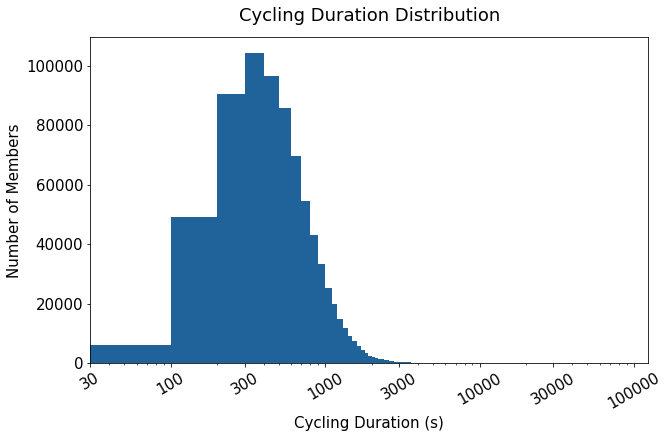

In [10]:
plt.figure(figsize=(10,6))
bins = np.arange(0, 86366+2000, 100)
sns.distplot(df.duration_sec, kde=False, color="#20639B", bins=bins, hist_kws={'alpha':1})
plt.xlabel("Cycling Duration (s)")
plt.ylabel("Number of Members");
plt.title("Cycling Duration Distribution", pad=16);
plt.xscale('log')
x_ticks = [30, 100, 300, 1000, 3000, 10000, 30000, 100000]
plt.xticks(x_ticks, x_ticks, rotation=30);

__There is a significant outlier in the data so a Threshold of 10000 will be applied to make the data more readable and consistent.__

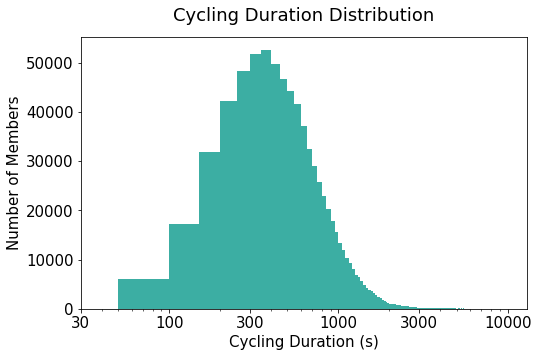

In [11]:
plt.figure(figsize=(8,5))
df = df[df.duration_sec < 10000]
bins = np.arange(0, 10000+50, 50)
sns.distplot(df.duration_sec, kde=False, color="#3CAEA3", bins=bins, hist_kws={'alpha':1})
plt.xlabel("Cycling Duration (s)")
plt.ylabel("Number of Members");
plt.title("Cycling Duration Distribution", pad=16);
plt.xscale('log')
x_ticks = [30, 100, 300, 1000, 3000, 10000]
plt.xticks(x_ticks, x_ticks);

__There is a Penalty of outliers in the data so a proper filter will be Applied under 10000.__

* A 'log' Scale was applied to make the data more readable. 
* most of the bikers use therir bikes for short times for around 400 sec($\approx$ 6.5minutes).

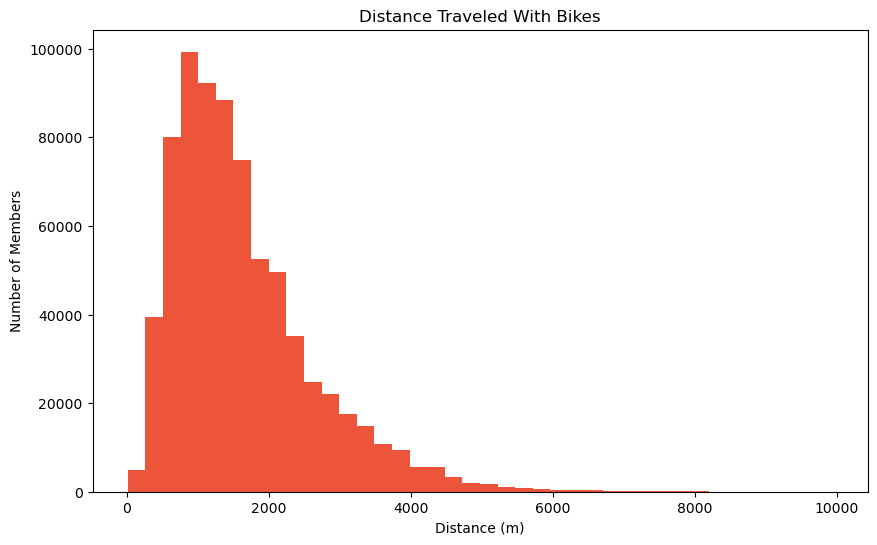

In [22]:
plt.figure(figsize=(10,6))
df = df[df.distance < 10000]
g2 = sns.distplot(df.distance, kde=False, color = "#ED553B", hist_kws={'alpha':1}, bins=40);
g2.set(xscale='linear', title='Distance Traveled With Bikes');
plt.xlabel("Distance (m)")
plt.ylabel("Number of Members");

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> The duration_sec and the 'distance' columns had some outliers that was removed, in addition to some other modifcations such as transformation to log scale. 

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Some feature engineering was applied to the coordinates of the stations in order to obtain the actual distance.

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

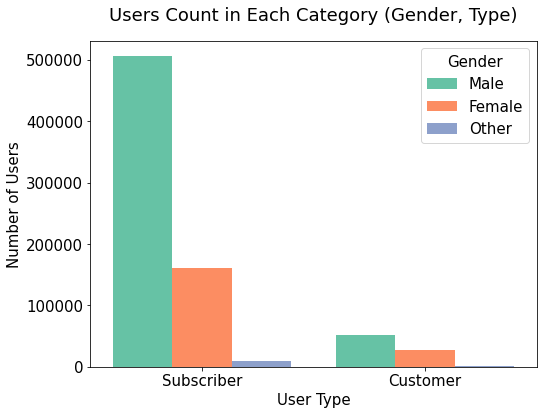

In [13]:
plt.figure(figsize=(8,6))
sns.countplot(x='user_type', data=df, hue='member_gender', palette='Set2',saturation=1)
plt.legend(title='Gender')
plt.xlabel("User Type")
plt.ylabel("Number of Users")
plt.title("Users Count in Each Category (Gender, Type)", pad=20);

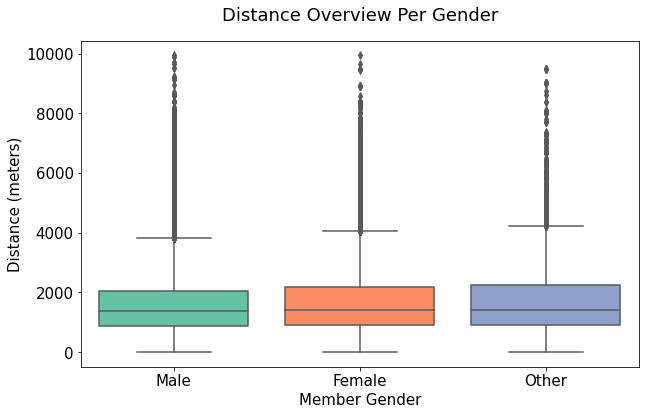

In [14]:
plt.figure(figsize=(10, 6))
df = df[df.distance < 20000]
df = df[df.member_birth_year > 1930]
sns.boxplot(y='distance', x='member_gender', data=df, palette='Set2', saturation=1)
plt.xlabel("Member Gender")
plt.ylabel("Distance (meters)")
plt.title("Distance Overview Per Gender", pad=20);

__Birth year vs. Gender.__

In [15]:
grp = df.groupby(['member_birth_year', 'member_gender'])
grp_size = grp.distance.size().reset_index()
grp_size = grp_size.pivot(index='member_birth_year', columns='member_gender', values='distance')
grp_size.fillna(0, inplace=True)
grp_size.index = grp_size.index.astype(int)
grp_size

member_gender,Female,Male,Other
1932,0.0,2.0,0.0
1933,121.0,0.0,0.0
1934,0.0,58.0,0.0
1935,0.0,89.0,0.0
1936,0.0,302.0,0.0
...,...,...,...
1996,3076.0,6791.0,10.0
1997,2633.0,5335.0,449.0
1998,1507.0,4813.0,23.0
1999,1022.0,2667.0,29.0


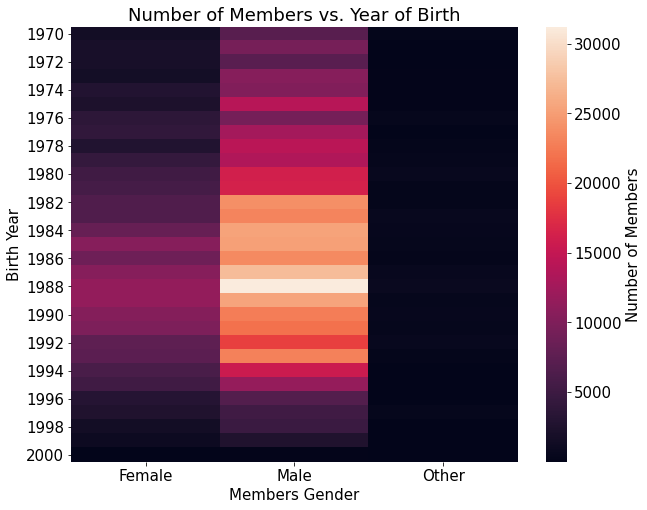

In [16]:
plt.figure(figsize=(10,8))
sns.heatmap(data=grp_size.loc[1970.0:,:], cbar_kws={'label':"Number of Members"});
plt.xlabel("Members Gender")
plt.ylabel("Birth Year")
plt.title("Number of Members vs. Year of Birth");

__From the graph, it is noted that:__
1. Male Members > Females Members.
2. Dominant year of birth $\approx$ 1981 -> 1995, which defines an age range of 23 -> 31.

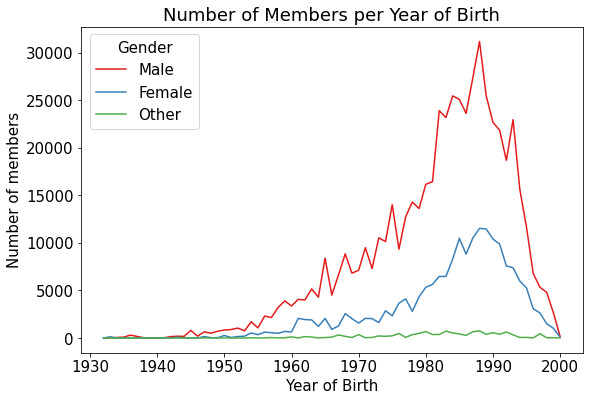

In [17]:
plt.figure(figsize=(9,6))
sns.lineplot(data=grp_size, dashes=False, palette='Set1',hue_order=['Male', 'Female', "Other"])
plt.xlabel("Year of Birth")
plt.title("Number of Members per Year of Birth")
plt.ylabel("Number of members")
plt.legend(bbox_to_anchor=(0.25,1), title="Gender");

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Year of birth and genders, the analysis stated that most customers are males and ages from 23 to 31.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> No, other featrues are still too vague to include.

# Multivariate Exploration

### 1. Average Distance Traveled per User Type And Gender.

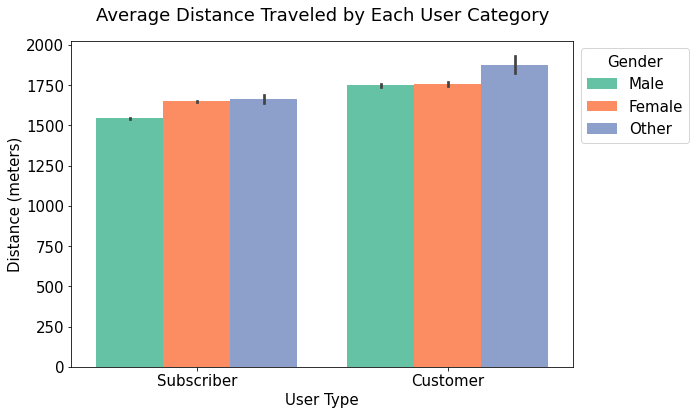

In [18]:
plt.figure(figsize=(9, 6))
sns.barplot(y='distance',x='user_type', data=df, hue='member_gender', palette="Set2", saturation=1)
plt.legend(bbox_to_anchor=(1,1), title="Gender")
plt.xlabel("User Type")
plt.ylabel("Distance (meters)")
plt.title("Average Distance Traveled by Each User Category", pad=20);

__Despite that the customers are traveling longer, there is still no strong relation between the distance and the user type.__

### 2. Average Time Spent Per User Type and Gender.

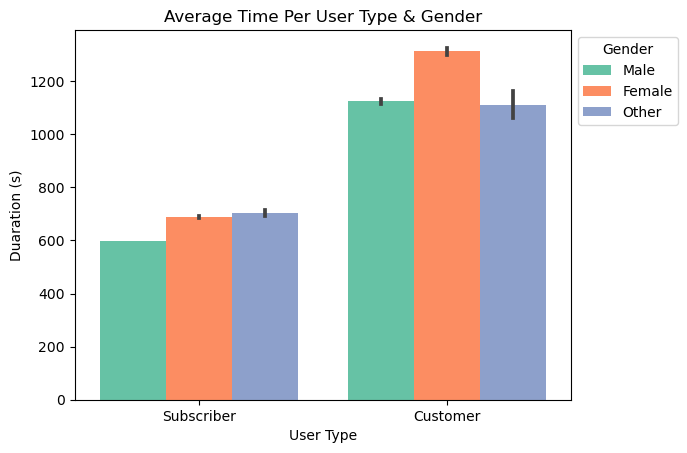

In [19]:
plt.style.use('default')
sns.barplot(y='duration_sec',x='user_type', data=df, hue='member_gender', palette="Set2", saturation=1)
plt.ylabel("Duaration (s)")
plt.xlabel("User Type")
plt.title("Average Time Per User Type & Gender")
plt.legend(bbox_to_anchor=(1,1), title="Gender");

* It looks like the customers are renting bikes more than customers, which indicates that the __pay-as-you-go stategy is more preferable than the subsciption packages__.
* Secondly, In the customers, Females are spending more time which contradictes The Previous observation, and the only explanation is that __females are a bit slower than other genders__ when driving a bike.

### 3. Relation between Month and Distance Per User Type.

In [20]:
df.distance = df.distance[df.distance > 0]
df.reset_index(drop=True, inplace=True)
df['month'] = df.start_time.dt.month_name()

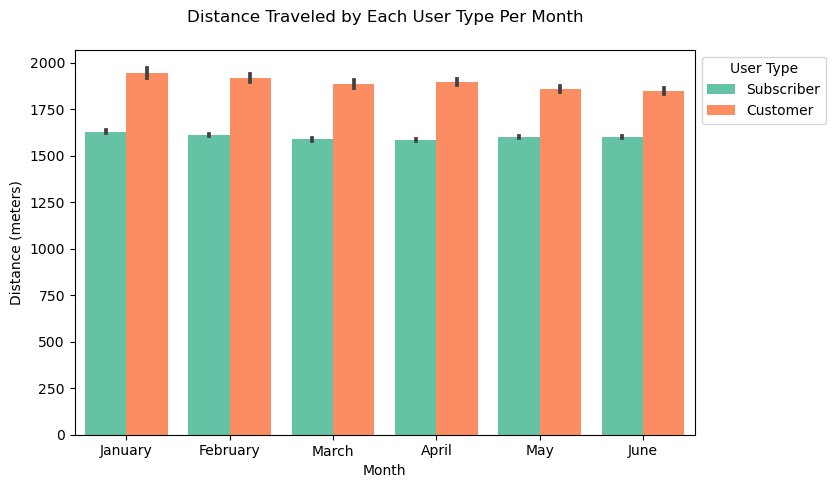

In [21]:
plt.figure(figsize=(8, 5))
sns.barplot(x='month', y='distance', hue='user_type', data=df, palette='Set2', saturation=1)
plt.xlabel("Month")
plt.ylabel("Distance (meters)")
plt.legend(bbox_to_anchor=(1,1), title="User Type")
plt.title("Distance Traveled by Each User Type Per Month", pad=20);

__Even when viewing each month seperately, the customer-type users are still the highest in the distance traveled.__

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Apparently, There was a strong relation between the duration, distance and the user type. Customer-type users are the dominant users; they have the highest duration and distances in all categories.

### Were there any interesting or surprising interactions between features?

> In regards to the distance, all genders are traveling, nearly, the same distance which is odd and optimistic in the same time, considering a study that was puplished early, which states that men are more likely to commute longer distances than women. 

In [70]:
df.to_csv('Frod_mod.csv', index=False)